In [13]:
import os

In [14]:
from itertools import islice

In [15]:
form_writer = {}
forms_file_path = "C:\\Users\\lenovo\\Desktop\\IAM\\ascii\\forms.txt"
with open(forms_file_path) as f:
    for line in islice(f, 16, None):
        line_list = line.split(' ')
        form_id = line_list[0]
        writer = line_list[1]
        form_writer[form_id] = writer

In [16]:
list(form_writer.items())[0:5]

[('a01-000u', '000'),
 ('a01-000x', '001'),
 ('a01-003', '002'),
 ('a01-003u', '000'),
 ('a01-003x', '003')]

In [17]:
from collections import Counter

In [18]:
top_writers = []
num_writers = 50
writers_counter = Counter(form_writer.values())
for writer_id,_ in writers_counter.most_common(num_writers):
    top_writers.append(writer_id)

In [19]:
print(top_writers[0:5])

['000', '150', '151', '152', '153']


In [20]:
top_forms = []
for form_id, author_id in form_writer.items():
    if author_id in top_writers:
        top_forms.append(form_id)

In [21]:
print(top_forms[0:5])
import cv2

['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u']


In [22]:
import os
import glob
import shutil
from matplotlib import pyplot as plt
import ntpath

In [ ]:
temp_sentences_path = "C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences"
if not os.path.exists(temp_sentences_path):
    os.makedirs(temp_sentences_path)
    # Copy forms that belong to the top 50 most common writers to the temp directory
original_sentences_path = "C:/Users/lenovo/Desktop/IAM/sentences/**/**/*.png"
#print(original_sentences_path)
for file_path in glob.glob(original_sentences_path):
    #print("1")
    image_name = file_path.split('/')[-1]  
    file_name, _ = os.path.splitext(image_name)
    image_name = ntpath.basename(file_path)
    file_name =file_name[14:-4]
    file_name1 = file_name.split("-")[0]
    file_name2 = file_path.split("-")[-3]
    file_name = file_name1 + "-" + file_name2
    #print(file_name)
    #form_id = '-'.join(file_name.split('-')[0:2])C:\Users\lenovo\Desktop\IAM\sentences\a01\a01-000u
    
    if file_name in top_forms:
        #print(file_name)
        #plt.imshow(cv2.imread(file_path))
        #plt.show()
        shutil.copy2(file_path, temp_sentences_path + "/" + image_name )
    
 
       

In [12]:
import numpy as np
temp_sentences_path = "C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences"
img_files = np.zeros((0), dtype=np.str)
img_targets = np.zeros((0), dtype=np.str)
path_to_files = os.path.join(temp_sentences_path, '*')
for file_path in glob.glob(path_to_files):
    img_files = np.append(img_files, file_path)
    #print(img_files)
    file_name, _ = os.path.splitext(file_path.split('/')[-1])
    image_name1 = ntpath.basename(file_name)
    #print(image_name1[:-7])
    form_id = image_name1[:-7]
    #print(form_id)
    for key in form_writer:
        #print(key)
        if key == form_id:
            img_targets = np.append(img_targets, form_writer[form_id])

In [24]:
print(len(img_files))
print(img_files[0:5])
print(img_targets[0:5])

4909
['C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences\\a01-000u-s00-00.png'
 'C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences\\a01-000u-s00-01.png'
 'C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences\\a01-000u-s00-02.png'
 'C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences\\a01-000u-s00-03.png'
 'C:\\Users\\lenovo\\Desktop\\IAM\\temp_sentences\\a01-000u-s01-00.png']
['000' '000' '000' '000' '000']


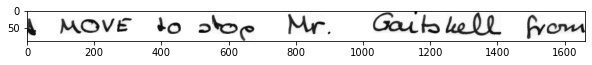

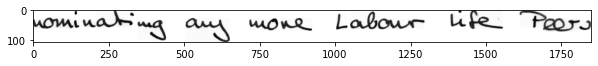

In [25]:
import matplotlib.image as mpimg
%matplotlib inline

for file_name in img_files[:2]:
    img = mpimg.imread(file_name)
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap ='gray')

In [26]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_img_targets = encoder.transform(img_targets)

print("Writer ID        : ", img_targets[:10])
print("Encoded writer ID: ", encoded_img_targets[:10])

Writer ID        :  ['000' '000' '000' '000' '000' '000' '000' '000' '000' '000']
Encoded writer ID:  [0 0 0 0 0 0 0 0 0 0]


In [27]:
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(img_files, encoded_img_targets, test_size=0.2, shuffle = True)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(3141,) (786,) (982,)
(3141,) (786,) (982,)


In [28]:
CROP_SIZE = 113
NUM_LABELS = 50
BATCH_SIZE = 16

In [29]:
from PIL import Image
import random

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return (images, labels)

Label:  24


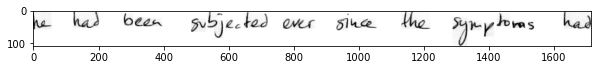

In [30]:
sample, label = X_train[0], y_train[0]
img = mpimg.imread(sample)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap ='gray')
print("Label: ", label)

In [31]:
images, labels = get_augmented_sample(sample, label, 0.1)

In [32]:
print(labels)
print("Num of labels: ", len(labels))

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
Num of labels:  168


168


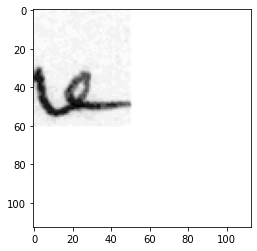

In [33]:
print(len(images))
plt.imshow(images[0], cmap ='gray')

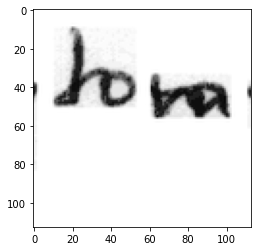

In [34]:
plt.imshow(images[1], cmap ='gray')

In [27]:
pip install --upgrade --no-deps --force-reinstall tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [35]:
import operator
from functools import reduce
from keras.utils import to_categorical

def generate_data(samples, labels, batch_size, sample_ratio):
    while 1: 
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:(offset + batch_size)]
            batch_labels = labels[offset:(offset + batch_size)]
            
            # Augment each sample in batch
            augmented_batch_samples = []
            augmented_batch_labels = []
            for i in range(len(batch_samples)):
                sample = batch_samples[i]
                label = batch_labels[i]
                augmented_samples, augmented_labels = get_augmented_sample(sample, label, sample_ratio)
                augmented_batch_samples.append(augmented_samples)
                augmented_batch_labels.append(augmented_labels)

            # Flatten out samples and labels
            augmented_batch_samples = reduce(operator.add, augmented_batch_samples)
            augmented_batch_labels = reduce(operator.add, augmented_batch_labels)
            
            # Reshape input format
            X_train = np.array(augmented_batch_samples)
            X_train = X_train.reshape(X_train.shape[0], CROP_SIZE, CROP_SIZE, 1)

            # Transform input to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            # Encode y
            y_train = np.array(augmented_batch_labels)
            y_train = to_categorical(y_train, NUM_LABELS)

            yield X_train, y_train

Using TensorFlow backend.


In [36]:
train_generator = generate_data(X_train, y_train, BATCH_SIZE, 0.3)
validation_generator = generate_data(X_val, y_val, BATCH_SIZE, 0.3)
test_generator = generate_data(X_test, y_test, BATCH_SIZE, 0.1)

In [53]:
tf.compat.v1.disable_v2_behavior()

In [57]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
tf.compat.v1.Session(config = config)

In [58]:
def resize_image(img):
    size = round(CROP_SIZE/2)
    return tf.image.resize(img, [size, size])

In [64]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from keras import metrics

model = Sequential()

# Define network input shape
model.add(ZeroPadding2D((1, 1), input_shape=(CROP_SIZE, CROP_SIZE, 1)))
# Resize images to allow for easy computation
model.add(Lambda(resize_image)) 

# CNN model - Building the model suggested in paper
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2, 2), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_LABELS, name='output'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_3 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 64)       

In [ ]:

from keras.callbacks import ModelCheckpoint

# Create directory to save checkpoints at
model_checkpoints_path = "C:/Users/lenovo/Desktop/IAM/m"
if not os.path.exists(model_checkpoints_path):
    os.makedirs(model_checkpoints_path)
    
# Save model after every epoch using checkpoints
create_checkpoint = ModelCheckpoint(
    filepath = "C:/Users/lenovo/Desktop/IAM/m/check_{epoch:02d}_{val_loss:.4f}.hdf5",
    verbose = 1,
    save_best_only = False
)

# Fit model using generators
history_object = model.fit_generator(
    train_generator, 
    steps_per_epoch = round(len(X_train) / BATCH_SIZE),
    validation_data = validation_generator,
    validation_steps = round(len(X_val) / BATCH_SIZE),
    epochs = 20,
    verbose = 1,
    callbacks = [create_checkpoint]
)

Epoch 1/20
  8/196 [>.............................] - ETA: 3:48:25 - loss: 3.9766 - acc: 0.1845 - ETA: 9:13:53 - loss: 3.8771 - acc: - ETA: 4:23:03 - loss: 4.0278 - acc: 0.

In [46]:
model_weights_path = "C:\\Users\lenovo\Desktop\IAM\m\m\model_weights.hdf5"
if model_weights_path:
    model.load_weights(model_weights_path)
    scores = model.evaluate_generator(test_generator, steps=round(len(X_test)/BATCH_SIZE))
    print("Accuracy: ", scores[1])
else:
    print("Set model weights file to load in the 'model_weights_path' variable")

Accuracy:  0.7002452611923218
